In [ ]:
!pip install -r requirements.txt

In [2]:
!curl -O https://blent-learning-user-ressources.s3.eu-west-3.amazonaws.com/projects/60fb61/brats_2019.zip 
!unzip -q brats_2019.zip -d data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2658M  100 2658M    0     0  63.9M      0  0:00:41  0:00:41 --:--:-- 30.7M


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import nibabel as nib
import os
import random
from pathlib import Path



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-07-03 14:34:21.988986: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 14:34:22.655535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751553262.887185    6883 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751553262.953440    6

# Dataset exploration

In [3]:
HGG_path = Path(("data/MICCAI_BraTS_2019_Data_Training/HGG/"))
LGG_path = Path(("data/MICCAI_BraTS_2019_Data_Training/LGG/"))

In [4]:

# Load NIfTI file from HGG
img = nib.load(os.path.join(HGG_path, "BraTS19_2013_2_1/BraTS19_2013_2_1_flair.nii"))
data = img.get_fdata()
data.shape



(240, 240, 155)

In [5]:
# Load NIfTI file from LGG
img = nib.load(os.path.join(LGG_path, "BraTS19_2013_0_1/BraTS19_2013_0_1_flair.nii"))
data = img.get_fdata()
data.shape

(240, 240, 155)

In [ ]:

# Plot a slice
plt.imshow(data[:, :, 80], cmap="gray") # coupe selon z=80 -> faire une video avec toutes les hauteurs? Couper selon les autres axes? 
plt.title("Middle slice of brain MRI")
plt.axis("off")
plt.show()

In [ ]:

imgs = []

# selectionner x patients au hasard
x = 10
patients = [p for p in HGG_path.iterdir() if p.is_dir()]
sampled_patients = random.sample(patients, x)
print(sampled_patients)

# Boucle sur les x patients
for patient in sampled_patients:
    print(patient.name)
    T1 = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t1.nii")
    T1CE = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t1ce.nii")
    T2 = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t2.nii")
    FLAIR = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_flair.nii")
    SEG = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_seg.nii")
    imgs.append([T1, T1CE, T2, FLAIR, SEG])


# Plot a slice
fig, axes = plt.subplots(x, 5, figsize=(20, x*4))  # x rows, 5 columns

for i, patient in enumerate(imgs):
    for j, img in enumerate(patient):
        data = img.get_fdata()
        ax = axes[i, j]
        ax.imshow(data[:, :, 80], cmap="gray")
        ax.set_title(f"Patient {i+1} - Img {j+1}")
        ax.axis("off")


# Pre rocessing
Nous avons des images en 240x240x155 et nous souhaitons les redimensionner en 240x240x144 (sans alterer les dimensions). \
Nous constatons que sur les grande majorite des images, le cerveau s'arrete a 147 pixels et commence a 3 pixels (sur l'axe z). \
Nous allons donc supprimer les 3 premieres couches ainsi que les 8 dernieres pour supprimer les couches vides et ainsi obtenir des parrallelepipedes de 240x240x144.

In [ ]:
data = data[:,:,3:147]
data.shape

## Save Dataset 2D dans un format .npy injectable dans tensorflow

- **Charger les volumes IRM FLAIR (`*_flair.nii`) et leurs segmentations associées (`*_seg.nii`) pour chaque patient HGG et LGG.**
- **Appliquer un crop** sur l’axe Z (profondeur) pour ne conserver que les 144 coupes centrales :  
  `volume[:, :, 3:147]` → dimensions finales : `(240, 240, 144)`
- **Découper chaque volume 3D** en slices 2D (une par coupe selon Z).
- **Sauvegarder chaque slice 2D au format `.npy`** dans la structure suivante :

dataset_UNET_2D/ \
| \
|- X/ \
|   |- HGG_BraTS19_XXX_slice_000.npy \
|   |- LGG_BraTS19_YYY_slice_001.npy \
|   |- ... \
| \
|- Y/ \
|   |- HGG_BraTS19_XXX_slice_000.npy \
|   |- LGG_BraTS19_YYY_slice_001.npy \
|   |- ... \

Chaque image dans `X/` correspond à une coupe IRM FLAIR normalisée, et chaque image dans `Y/` est le masque de segmentation associé.

Le dossier `dataset_UNET_2D/` constitué de slices 2D prétraitées (entrées FLAIR et masques) constitue la **base d’apprentissage pour le modèle U-Net**, en vue d’une **segmentation précise des zones tumorales sur chaque coupe IRM**.

In [10]:
import numpy as np
import nibabel as nib
from pathlib import Path

# Chemins d’entrée
HGG_path = Path("data/MICCAI_BraTS_2019_Data_Training/HGG")
LGG_path = Path("data/MICCAI_BraTS_2019_Data_Training/LGG")

# Chemins de sortie
output_X_2D = Path("data/MICCAI_BraTS_2019_Data_Training/dataset_UNET_2D/X")
output_Y_2D = Path("data/MICCAI_BraTS_2019_Data_Training/dataset_UNET_2D/Y")

output_X_2D.mkdir(parents=True, exist_ok=True)
output_Y_2D.mkdir(parents=True, exist_ok=True)

def process_patient(patient_dir, tumor_type):
    try:
        patient_id = patient_dir.name
        flair_path = patient_dir / f"{patient_id}_flair.nii"
        seg_path = patient_dir / f"{patient_id}_seg.nii"

        flair_data = nib.load(flair_path).get_fdata()[:, :, 3:147]  # crop en Z
        seg_data = nib.load(seg_path).get_fdata()[:, :, 3:147]      # crop en Z

        # Générer des slices suivant Z
        for i in range(flair_data.shape[2]):
            img_slice = flair_data[:, :, i]
            seg_slice = seg_data[:, :, i]

            # Sauvegarde au format .npy
            slice_name = f"{tumor_type}_{patient_id}_slice_{i:03}"
            np.save(output_X_2D / f"{slice_name}.npy", img_slice)
            np.save(output_Y_2D / f"{slice_name}.npy", seg_slice)

    except Exception as e:
        print(f"Erreur avec {patient_dir.name}: {e}")

# Appliquer à HGG et LGG
for patient in HGG_path.iterdir():
    if patient.is_dir():
        process_patient(patient, tumor_type="HGG")

for patient in LGG_path.iterdir():
    if patient.is_dir():
        process_patient(patient, tumor_type="LGG")

# Training

## UNET

### Creation Dataset

In [7]:
import tensorflow as tf
import numpy as np
import glob

X_paths = sorted(glob.glob(("data/MICCAI_BraTS_2019_Data_Training/dataset_UNET_2D/X/*.npy")))
Y_paths = sorted(glob.glob(("data/MICCAI_BraTS_2019_Data_Training/dataset_UNET_2D/Y/*.npy")))

def load_npy_pair(x_path, y_path):
    x = np.load(x_path.decode()).astype(np.float32)
    y = np.load(y_path.decode()).astype(np.int32)

    # Test de validité des classes du masque
    # TEMP : Affiche les valeurs uniques du masque
    # print("UNIQUE LABELS IN y:", np.unique(y))
    assert np.all(np.isin(y, [0, 1, 2, 4])), "Masque invalide : valeurs inattendues dans y"
    # Remap classes 4 → 3
    y[y == 4] = 3

    # Normalisation min-max slice par slice
    if x.max() > 0:  # éviter division par zéro
        x = x / x.max()

    # Remplacement des NaN éventuels
    x = np.nan_to_num(x)

    x = np.expand_dims(x, axis=-1)  # (240, 240, 1)
    y = np.expand_dims(y, axis=-1)
    return x, y

def tf_wrapper(x_path, y_path):
    x, y = tf.numpy_function(load_npy_pair, [x_path, y_path], [tf.float32, tf.int32])

    # Définir manuellement les shapes pour TensorFlow
    x.set_shape((240, 240, 1))
    y.set_shape((240, 240, 1))
    return x, y

# Fonction de construction du dataset
def make_dataset(data_pairs, batch_size=8):
    X, Y = zip(*data_pairs)
    ds = tf.data.Dataset.from_tensor_slices((list(X), list(Y)))
    ds = ds.map(tf_wrapper)
    ds = ds.shuffle(100)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE) # pipeline asynchrone optimisé
    return ds



### Creation model

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical
from keras import backend as K

def encoding_layer(input_layer,output_channels,kernel_size):
    conv1 = Conv2D(output_channels, (kernel_size, kernel_size), activation='relu', padding='same',\
                   kernel_initializer=tf.random_normal_initializer(0, 0.02)) (input_layer)
    return conv1

def bottleneck_layer(input_layer,output_channels,kernel_size):
    bottleneck1 = Conv2D(output_channels, (kernel_size, kernel_size), activation='relu', padding='same',\
                         kernel_initializer=tf.random_normal_initializer(0, 0.02)) (input_layer)
    bottleneck2 = Conv2D(output_channels, (kernel_size, kernel_size), activation='relu', padding='same',\
                         kernel_initializer=tf.random_normal_initializer(0, 0.02)) (bottleneck1)
    return bottleneck2

def decoding_layer(input_layer,skip_layer,output_channels,kernel_size,stride):
    upconv1 = Conv2DTranspose(output_channels,  (kernel_size, kernel_size),strides=(stride,stride), padding='same',\
                              kernel_initializer=tf.random_normal_initializer(0, 0.02)) (input_layer)
    concat1 = concatenate([upconv1, skip_layer])
    conv1 = Conv2D(output_channels, kernel_size, activation='relu', padding='same',\
                   kernel_initializer=tf.random_normal_initializer(0, 0.02)) (concat1)
    return conv1

def create_unet(input_shape=(240,240,1), num_classes=4):
    inputs_coarse = Input(input_shape)

    encoding_layer1=encoding_layer(inputs_coarse,64,3)
    pool1 = MaxPooling2D((2, 2),padding='same') (encoding_layer1)
    encoding_layer2=encoding_layer(pool1,128,3)
    pool2 = MaxPooling2D((2, 2),padding='same') (encoding_layer2)
    encoding_layer3=encoding_layer(pool2,256,3)
    pool3 = MaxPooling2D((2, 2),padding='same') (encoding_layer3)
    encoding_layer4=encoding_layer(pool3,512,3)
    pool4 = MaxPooling2D((2, 2),padding='same') (encoding_layer4)

    bottleneck=bottleneck_layer(pool4,1024,3)

    decoding_layer1= decoding_layer(bottleneck,encoding_layer4,512,3,2)
    decoding_layer2= decoding_layer(decoding_layer1,encoding_layer3,256,3,2)
    decoding_layer3 = decoding_layer(decoding_layer2,encoding_layer2,128,3,2)
    decoding_layer4 = decoding_layer(decoding_layer3,encoding_layer1,64,3,2)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax') (decoding_layer4)

    model = Model(inputs=inputs_coarse, outputs=[outputs])
    optim=Adam(learning_rate=0.0001)
    model.compile(optimizer=optim, loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])
    model.summary()
    return model

### Training avec Tensorboard

In [9]:
# Lancer dans un terminal la commande: tensorboard --logdir "./logs"

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import os

EPOCH = 3
BATCH_SIZE = 8

In [52]:
import random
# Creation du dataset

## Créer les paires
data = list(zip(X_paths, Y_paths))
random.shuffle(data)

## Split Dataset Train, Val, Test
n = len(data)
train_data = data[:int(0.8*n)]
val_data   = data[int(0.8*n):int(0.95*n)]
test_data  = data[int(0.95*n):]

# Reduction du datset pour debug
# train_data = train_data[:len(train_data)//5]
# val_data = val_data[:len(val_data)//5]
test_data = test_data[:len(test_data)//2]

train_ds = make_dataset(train_data, batch_size=BATCH_SIZE)
val_ds   = make_dataset(val_data, batch_size=BATCH_SIZE)
test_ds  = make_dataset(test_data, batch_size=BATCH_SIZE)


In [11]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

import tensorflow as tf
print(tf.__version__)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.19.0


In [16]:
# Creation du model
model = create_unet()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 240, 240, 64)         640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 120, 120, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 120, 120, 128)        73856     ['max_pooling2d[0][0]']   

In [17]:

from datetime import datetime

tensorboard_callback_unet = TensorBoard(log_dir=("logs/unet"+datetime.now().strftime("%Y%m%d-%H%M%S")))

model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[
        tensorboard_callback_unet, 
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint("checkpoints/unet_best.h5", monitor='val_loss', save_best_only=True)
        ]
)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


Epoch 1/3


I0000 00:00:1751547912.768334   19983 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751547927.978139   19983 service.cc:152] XLA service 0x7f8a0a0b1380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751547927.978166   19983 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-07-03 13:05:28.035756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751547929.276675   19983 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4824/4824 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9915

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


4824/4824 [==============================] - 1359s 275ms/step - loss: 0.0324 - accuracy: 0.9915 - val_loss: 0.0180 - val_accuracy: 0.9932
Epoch 2/3
4824/4824 [==============================] - 1322s 274ms/step - loss: 0.0160 - accuracy: 0.9940 - val_loss: 0.0145 - val_accuracy: 0.9946
Epoch 3/3
4824/4824 [==============================] - 1315s 273ms/step - loss: 0.0121 - accuracy: 0.9953 - val_loss: 0.0110 - val_accuracy: 0.9957


In [18]:
model.evaluate(test_ds)

603/603 [==============================] - 56s 91ms/step - loss: 0.0112 - accuracy: 0.9956


[0.011160311289131641, 0.9956421852111816]

In [63]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# Load best model
# Lien du model: https://drive.google.com/file/d/1HmYfTN_u3WyNwxJLp2943ULw1m2a0Ws4/view?usp=sharing 

loaded_model = load_model("checkpoints/unet_best.h5")

class_names = ['Fond', 'Nécrose', 'Œdème', 'Rehaussement']

# Display FLAIR, ground truth and prediciton
def display_prediction(model, dataset, class_names=class_names, num_samples=3):
    """
    Affiche des échantillons (FLAIR, masque GT, prédiction) à partir du modèle et du dataset.

    Args:
        model: modèle Keras entraîné
        dataset: tf.data.Dataset (ex: val_ds ou test_ds)
        class_names: liste des noms de classes (ex: ['fond', 'nécrose', 'œdème', 'rehaussement'])
        num_samples: nombre d’échantillons à afficher
    """

    for x_batch, y_batch in dataset.take(1):
        preds = model.predict(x_batch)

        # Convertir softmax → classe prédite (par pixel)
        preds_classes = np.argmax(preds, axis=-1)
        y_true_classes = np.squeeze(y_batch.numpy(), axis=-1)
        
        # Limite au nombre réel d’images dans le batch
        n = min(num_samples, x_batch.shape[0])
        
        for i in range(num_samples):
            img = np.squeeze(x_batch[i].numpy(), axis=-1)
            gt = y_true_classes[i]
            pred = preds_classes[i]

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            titles = ['FLAIR slice', 'Ground truth mask', 'Predicted mask']

            for j, data in enumerate([img, gt, pred]):
                axes[j].imshow(data, cmap='gray' if j == 0 else 'nipy_spectral', vmin=0, vmax=3)
                axes[j].set_title(titles[j])
                axes[j].axis('off')

            if class_names:
                cmap = plt.get_cmap('nipy_spectral')
                patches = [plt.plot([],[], marker="s", ls="", color=cmap(i/len(class_names)))[0]
                           for i in range(len(class_names))]
                plt.legend(patches, class_names, bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.tight_layout()
            plt.show()
            

# Binarise output and add threshold to match evaluation metrics precision/recall
def display_prediction_binarised(model, dataset, class_names=class_names,
                       num_samples=3, thresh=0.30):
    """
    Affiche FLAIR, masque Ground-Truth et prédiction binaire (seuil > `thresh`)
    pour `num_samples` coupes issues du premier batch du dataset.
    """
    for x_batch, y_batch in dataset.take(1):
        preds = model.predict(x_batch, verbose=0)

        # probabilité totale « tumeur »  = somme des classes 1-2-3
        tumor_prob = preds[..., 1:].sum(axis=-1)

        # Binarisation à `thresh`
        pred_bin = (tumor_prob > thresh).astype(np.uint8)

        # GT (binaire pareil) pour lecture plus claire
        y_true_bin = (tf.squeeze(y_batch, axis=-1).numpy() > 0).astype(np.uint8)

        n = min(num_samples, x_batch.shape[0])
        for i in range(n):
            img  = np.squeeze(x_batch[i].numpy(), axis=-1)
            gt   = y_true_bin[i]
            pred = pred_bin[i]

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            titles = ['FLAIR slice',
                      'Ground-truth (binaire)',
                      f'Predicted mask\n(thresh {thresh})']

            for ax, data, title in zip(axes,
                                       [img, gt, pred],
                                       titles):
                ax.imshow(data,
                          cmap='gray' if data.ndim == 2 and data.max() <= 1
                                     else 'nipy_spectral',
                          vmin=0, vmax=1)
                ax.set_title(title)
                ax.axis('off')

            plt.tight_layout()
            plt.show()

1/1 [==============================] - 0s 23ms/step


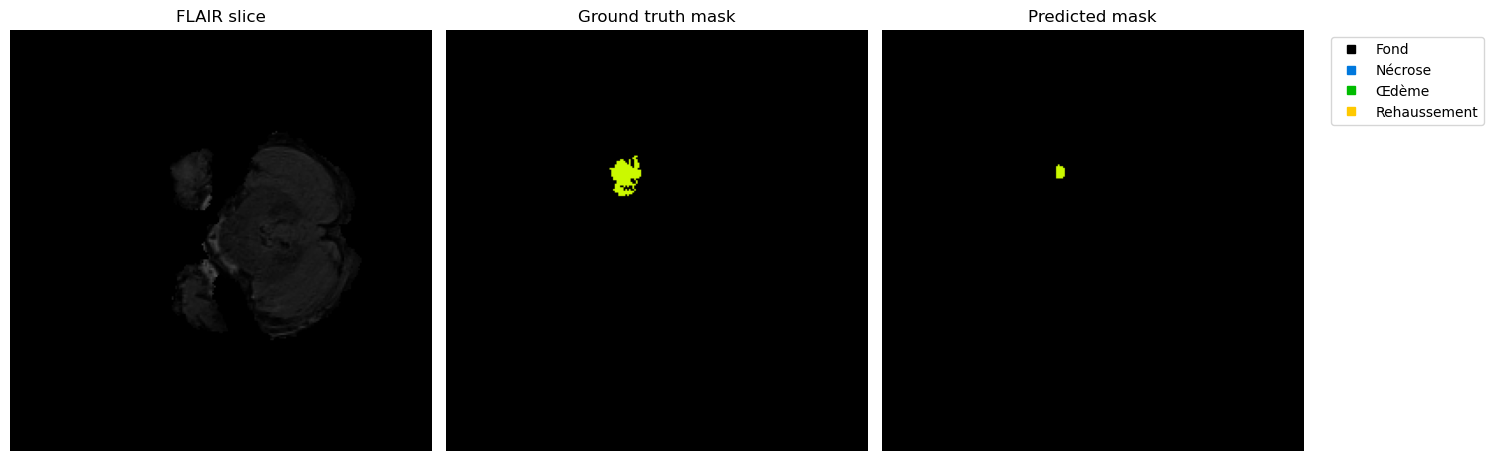

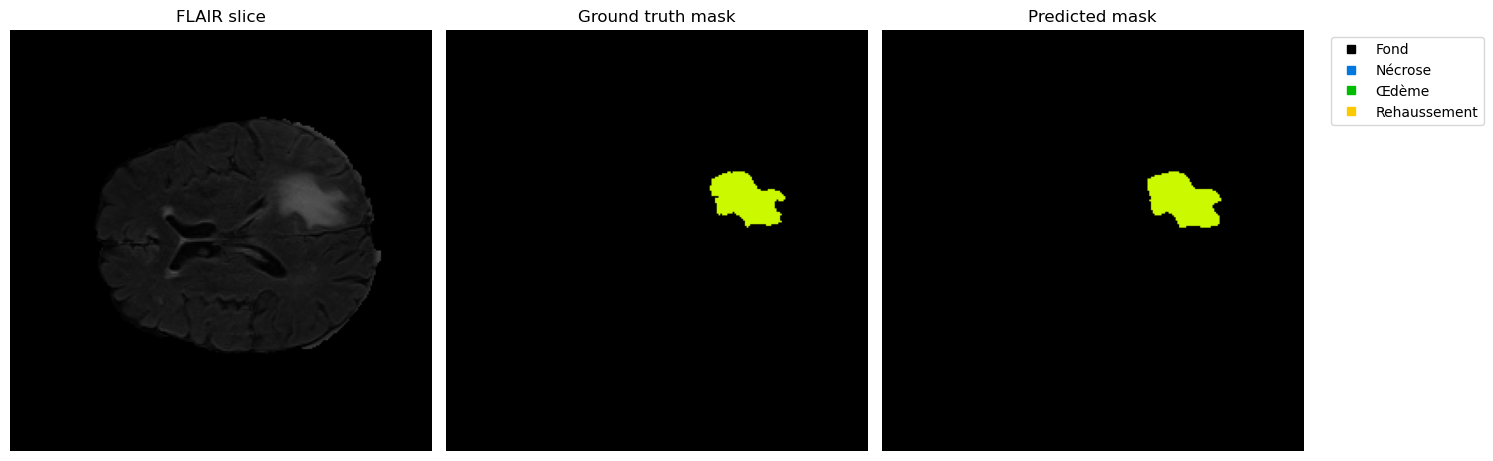

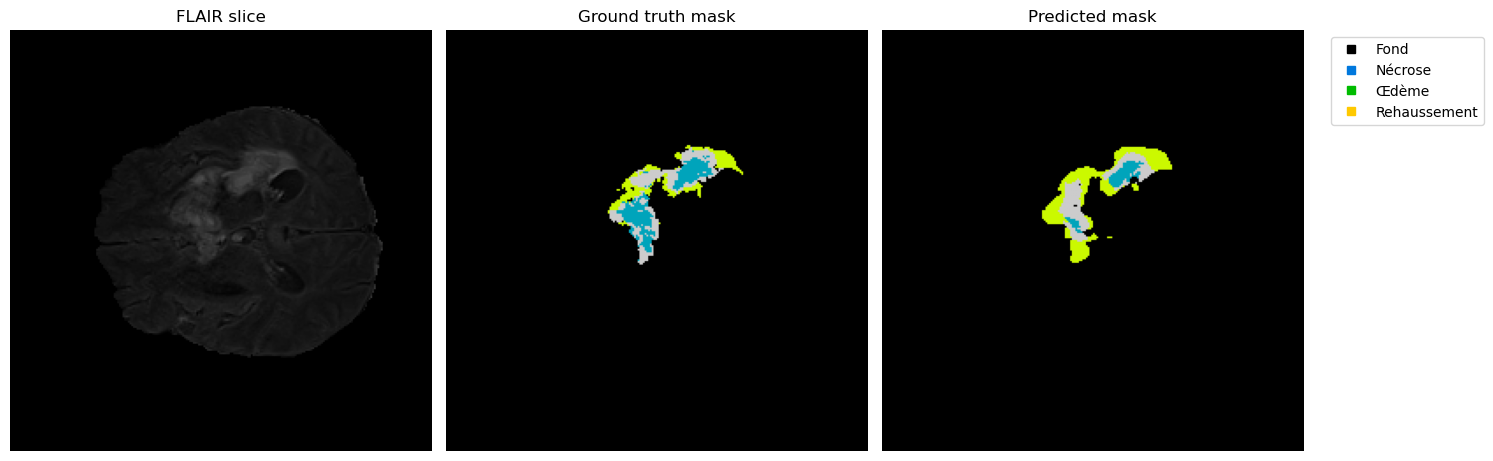

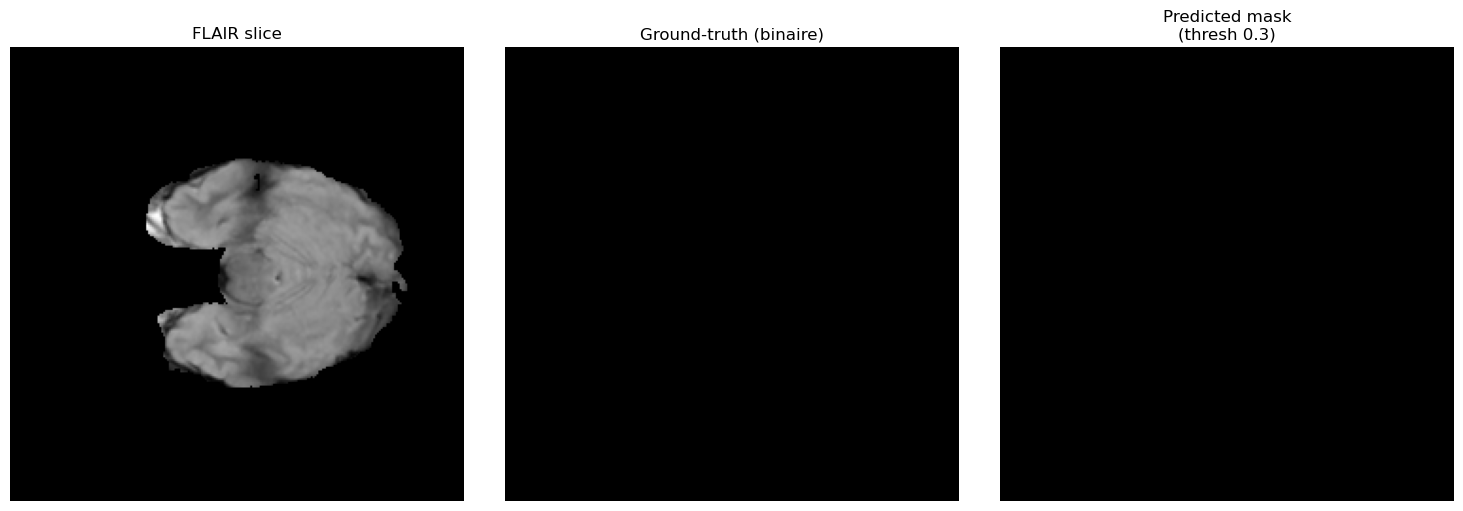

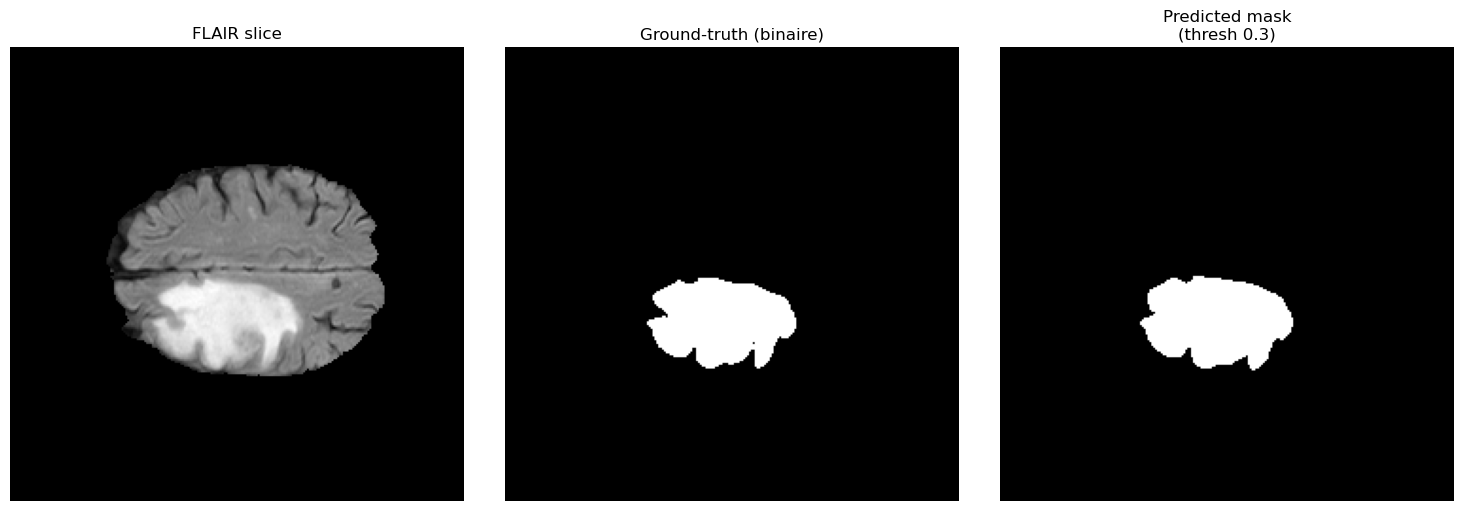

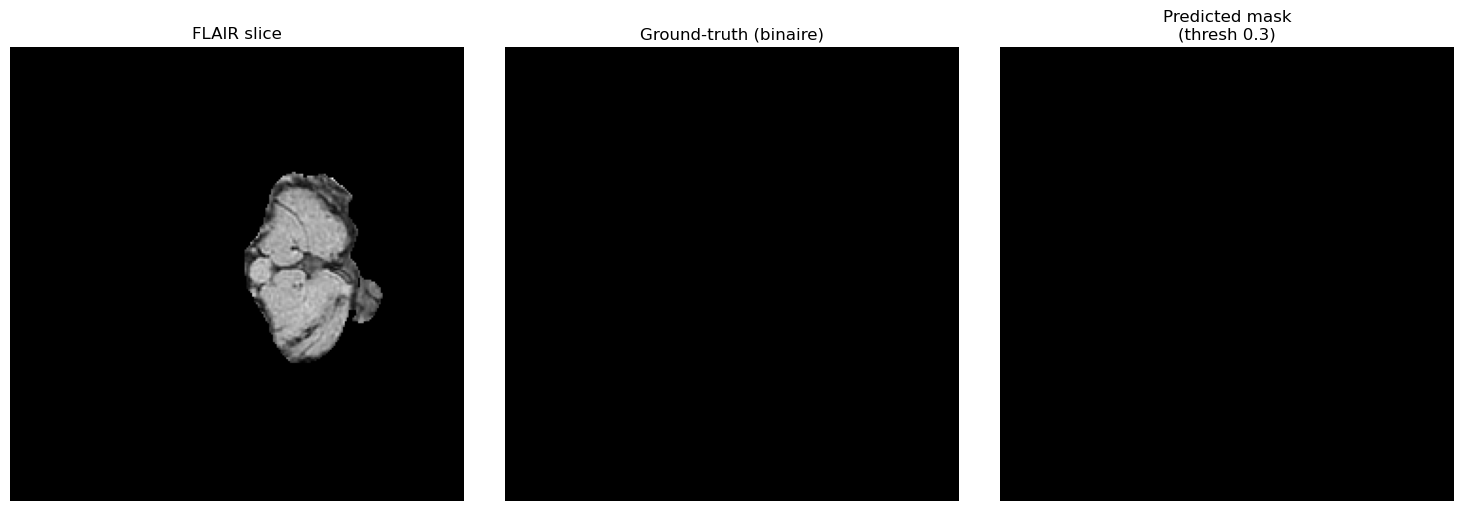

In [65]:
display_prediction(loaded_model, test_ds, num_samples=3)
display_prediction_binarised(loaded_model, test_ds, num_samples=3, thresh=0.3)

# Evaluation

In [22]:
# On verifie que le test dataset contient des valeurs
print(sum(1 for _ in test_ds))
for xb, yb in test_ds.take(1):
    print(xb.shape)


302
(8, 240, 240, 1)


2025-07-03 14:47:26.081043: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [54]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def evaluate_segmentation(model, dataset):
    """
    Calcule Recall & Precision sans créer d’énormes listes.
    Binarisation : tumeur = 1 (classes > 0), fond = 0.
    """
    tp = fp = fn = 0   # compteurs globaux

    for xb, yb in tqdm(dataset, desc="Evaluating", unit="batch"):
        preds = loaded_model.predict(xb, verbose=0)        # (B,240,240,4)
        tumor_prob = preds[..., 1:].sum(axis=-1)            # prob(tumeur) ∈ [0,1]
        pred_bin   = tumor_prob > 0.3                     # 0.25 = seuil plus bas
        true_bin = (tf.squeeze(yb, axis=-1).numpy() > 0)    # bool (B,H,W)

        tp += np.logical_and(pred_bin,  true_bin).sum()     # vrais positifs
        fp += np.logical_and(pred_bin, ~true_bin).sum()     # faux positifs
        fn += np.logical_and(~pred_bin,  true_bin).sum()    # faux négatifs

    if tp + fn == 0:
        print("Aucun pixel tumoral dans le jeu d’éval.")
        return None, None

    recall    = tp / (tp + fn)
    precision = tp / (tp + fp) if (tp + fp) else 0.0

    print(f"Recall   : {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    return recall, precision

In [55]:
recall, precision = evaluate_segmentation(loaded_model, test_ds)

Evaluating: 100%|██████████| 151/151 [00:23<00:00,  6.34batch/s]

Recall   : 0.9600
Precision: 0.8764
